Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


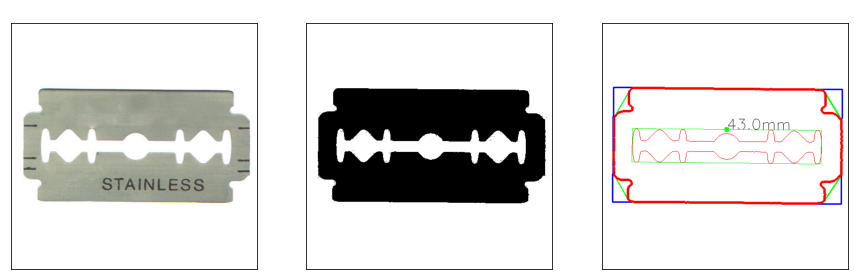

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


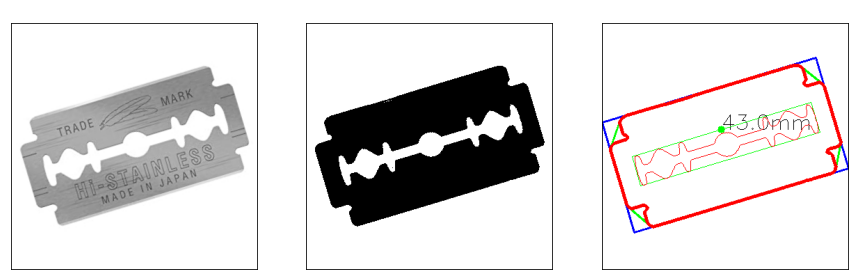

Matching: 958.4213549007437


In [4]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import math, os

def ratio(size):
    size = 43/size
    return size

def midpoint(x1, y1, x2, y2):
    return((x1 + x2) // 2, (y1 + y2) // 2)

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

def rect_dim(l1, l2, l5, l6, l7, l8):
    w = math.sqrt((l5 - l7) * (l5 - l7) + (l8 - l6) * (l8 - l6))
    h = math.sqrt((l7 - l1) * (l7 - l1) + (l8 - l2) * (l8 - l2))
    return w, h

sm_c = []
for i in load_images_from_folder("/home/dawid/repos/OpenCV-Features/images/blades"):
    img = i
    img_gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    white_img = np.zeros([img.shape[0],img.shape[1],3])
    
    h = len(white_img[1])
    w = len(white_img[0])

    for y in range(h):
        for x in range(w):
            white_img[y,x] = [255,255,255]

    
    ret,thresh = cv.threshold(img_gray, 247, 255,0)

    contours, hier = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)
    c1 = []
    for c in contours:
        area = cv.contourArea(c)
        # Smaller contour
        if area > 4000 and area < 20000:
            
            rect = cv.minAreaRect(c)
            box = np.int0(cv.boxPoints(rect))

            w = round(rect_dim(box[0][0], box[0][1], box[2][0], box[2][1], box[3][0], box[3][1])[0], 3)
            h = round(rect_dim(box[0][0], box[0][1], box[2][0], box[2][1], box[3][0], box[3][1])[1], 3)

            if w > h:
                cv.circle(white_img, midpoint(box[0][0], box[0][1], box[1][0], box[1][1]), 5, (0,255,0), -1)
                cv.putText(white_img, '%s'%round(ratio(w)*w,3)+"mm", midpoint(box[0][0], box[0][1], box[1][0], box[1][1]), cv.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 1, cv.LINE_AA)
            else:
                cv.putText(white_img, '%s'%round(ratio(w)*w,3)+"mm", midpoint(box[1][0], box[1][1], box[2][0], box[2][1]), cv.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 1, cv.LINE_AA)
                cv.circle(white_img, midpoint(box[1][0], box[1][1], box[2][0], box[2][1]), 5, (0,255,0), -1)
                
            
            cv.drawContours(white_img, [box], 0, (0,255,0), 1)
            cv.drawContours(white_img, c, -1, (255, 0, 0), 1)
            
            c1.append(c)
        # Bigger contour
        if area > 30000 and area < 100000:
            rect = cv.minAreaRect(c)
            box = np.int0(cv.boxPoints(rect))
            w = round(rect_dim(box[0][0], box[0][1], box[2][0], box[2][1], box[3][0], box[3][1])[0], 3)
            h = round(rect_dim(box[0][0], box[0][1], box[2][0], box[2][1], box[3][0], box[3][1])[1], 3)
            hull = cv.convexHull(c,returnPoints = False)
            defects = cv.convexityDefects(c,hull)

            for i in range(defects.shape[0]):
                s,e,f,d = defects[i,0]
                start = tuple(c[s][0])
                end = tuple(c[e][0])
                far = tuple(c[f][0])
                line = cv.line(white_img,start,end,[0,255,0],2)
            
            cv.drawContours(white_img, [box], 0, (0,0,255), 2)
            cv.drawContours(white_img, c, -1, (255, 0, 0), 4) 
    sm_c.append(c1)
    
    titles = ['Original Image','Threshold','Contours on mask']
    images = [img, thresh, white_img]
    
    for i in range(3):
        plt.rcParams["figure.figsize"]=15, 15
        plt.subplot(2,3,i+1),plt.imshow(images[i],'gray',vmin=0,vmax=255)
        plt.title(titles[i])
        plt.xticks([]),plt.yticks([])
        params = {"text.color" : "white"}
        plt.rcParams.update(params)
    
    plt.show()
ret = cv.matchShapes(sm_c[0][0],sm_c[1][0], 1, 0.0)
print("Matching: %s"%ret)